# Tarea 3 Agustin Vargas Quesada

Para la Tarea #3 se realizara un analisis predictivo haciendo uso del conjunto de datos de "VideoGamesSales.csv" el cual consiste en datos de las ventas de video juegos en diferentes años junto con las ventas que estos tuvieron.

Se va a predecir si un video juego genero perdidas o ganancias para la compañia de acuerdo a sus ventas. Para esto se utilizaran las columnas de prediction y resultado.

Para realizar el analisis se utilizara pyspark, lo primero que se debera de hacer es realizar las importaciones que se utilizaran, las cuales seran las siguientes:

In [1]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
from pyspark.sql.functions import col, desc, min, max, rand, when, avg, count
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import RandomForestClassifier

Una vez que se realizaron las importaciones que se requieren se debera de crear la sesion de la siguiente manera:

In [2]:
spark = SparkSession \
    .builder \
    .appName("Video Games") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()


ps: unrecognized option: p
BusyBox v1.30.1 (2019-10-26 11:23:07 UTC) multi-call binary.

Usage: ps [-o COL1,COL2=HEADER]

Show list of processes

	-o COL1,COL2=HEADER	Select columns for display
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/25 16:11:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


Una vez que se creo la sesion se debera de realizar la lectura del data set sobre el cual se va a trabajar :

In [3]:
schema = StructType([
    StructField("Rank", IntegerType(), True),
    StructField("Name", StringType(), True),
    StructField("Platform", StringType(), True),
    StructField("Year", IntegerType(), True),
    StructField("Genre", StringType(), True),
    StructField("Publisher", StringType(), True),
    StructField("NA_Sales", DoubleType(), True),
    StructField("EU_Sales", DoubleType(), True),
    StructField("JP_Sales", DoubleType(), True),
    StructField("Other_Sales", DoubleType(), True),
    StructField("Global_Sales", DoubleType(), True)
])

df = spark.read \
    .option("header", "true") \
    .schema(schema) \
    .csv("VideoGamesSales.csv")

df.show()
df.printSchema()

+----+--------------------+--------+----+------------+--------------------+--------+--------+--------+-----------+------------+
|Rank|                Name|Platform|Year|       Genre|           Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|
+----+--------------------+--------+----+------------+--------------------+--------+--------+--------+-----------+------------+
|   1|          Wii Sports|     Wii|2006|      Sports|            Nintendo|   41.49|   29.02|    3.77|       8.46|       82.74|
|   2|   Super Mario Bros.|     NES|1985|    Platform|            Nintendo|   29.08|    3.58|    6.81|       0.77|       40.24|
|   3|      Mario Kart Wii|     Wii|2008|      Racing|            Nintendo|   15.85|   12.88|    3.79|       3.31|       35.82|
|   4|   Wii Sports Resort|     Wii|2009|      Sports|            Nintendo|   15.75|   11.01|    3.28|       2.96|        33.0|
|   5|Pokemon Red/Pokem...|      GB|1996|Role-Playing|            Nintendo|   11.27|    8.89|   10.22|  

En las primeras 20 columnas da la impresion de que los datos no cuentan con valores anomalos, antes de empezar con el analisis es importatne realizar una exploracion de los datos, lo primero sera verificar si hay valores nulos, outliers o valores en cero, para esto lo realizaremos de la siguiente manera:

In [4]:
for column in df.columns:
    null_count = df.filter(col(column).isNull()).count()
    zero_count = df.filter(col(column) == 0).count()
        
    print(f"\nColumna: {column}")
    print(f"Valores NULL: {null_count}")
    print(f"Valores cero: {zero_count}")


Columna: Rank
Valores NULL: 0
Valores cero: 0

Columna: Name
Valores NULL: 0
Valores cero: 0

Columna: Platform
Valores NULL: 0
Valores cero: 0

Columna: Year
Valores NULL: 271
Valores cero: 0

Columna: Genre
Valores NULL: 0
Valores cero: 0

Columna: Publisher
Valores NULL: 0
Valores cero: 0

Columna: NA_Sales
Valores NULL: 0
Valores cero: 4499

Columna: EU_Sales
Valores NULL: 0
Valores cero: 5730

Columna: JP_Sales
Valores NULL: 0
Valores cero: 10455

Columna: Other_Sales
Valores NULL: 0
Valores cero: 6477

Columna: Global_Sales
Valores NULL: 0
Valores cero: 0


Primero se verificaran si hay valores nulos o valores numericos que sean 0, de acuerdo a la salida anterior se puede observar que las columnas NA_Sales que corresponde a las ventas de America del Norte, EU_Sales las ventas de Europa, JP_Sales ventas en japon y Other_Sales otras ventas, contienen valores numericos que son 0. Pero se observa que en el año se encuentran algunos registros nulos.


Estadísticas para NA_Sales:
Límite inferior: -0.30
Límite superior: 0.50
Número de outliers: 2040

Estadísticas para EU_Sales:
Límite inferior: -0.14
Límite superior: 0.23
Número de outliers: 2448

Estadísticas para JP_Sales:
Límite inferior: -0.03
Límite superior: 0.05
Número de outliers: 3465

Estadísticas para Other_Sales:
Límite inferior: -0.04
Límite superior: 0.07
Número de outliers: 2264

Estadísticas para Global_Sales:
Límite inferior: -0.46
Límite superior: 0.93
Número de outliers: 2218


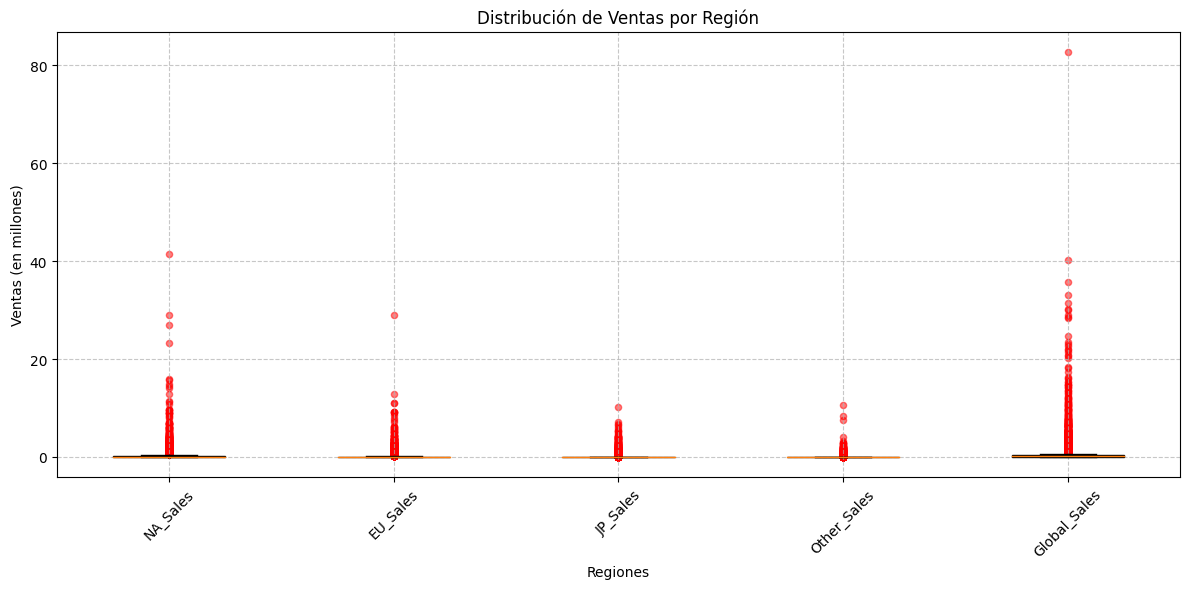

In [5]:
def plot_boxplot(df, columnas_numericas):
    fig, ax = plt.subplots(figsize=(12, 6))
    all_data = []
    
    for columna in columnas_numericas:
        quantiles = df.approxQuantile(columna, [0.25, 0.75], 0.05)
        Q1 = quantiles[0]
        Q3 = quantiles[1]
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        filtered_data = df.filter(
            (col(columna) >= lower_bound) & 
            (col(columna) <= upper_bound)
        ).select(columna).rdd.flatMap(lambda x: x).collect()
        
        outliers = df.filter(
            (col(columna) < lower_bound) | 
            (col(columna) > upper_bound)
        ).select(columna).rdd.flatMap(lambda x: x).collect()
        
        all_data.append({
            'data': filtered_data if filtered_data else [],
            'outliers': outliers,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        })
        
        print(f"\nEstadísticas para {columna}:")
        print(f"Límite inferior: {lower_bound:.2f}")
        print(f"Límite superior: {upper_bound:.2f}")
        print(f"Número de outliers: {len(outliers)}")
    
    bplot = ax.boxplot([item['data'] for item in all_data], 
                      labels=columnas_numericas,
                      patch_artist=True,
                      showfliers=False)
    
    colors = ['lightblue', 'lightgreen', 'lightsalmon', 'lightpink', 'lightyellow']
    for patch, color in zip(bplot['boxes'], colors[:len(columnas_numericas)]):
        patch.set_facecolor(color)
    
    for i, item in enumerate(all_data):
        if item['outliers']:
            ax.scatter([i+1] * len(item['outliers']), item['outliers'], 
                      color='red', alpha=0.5, s=20)
    
    plt.title('Distribución de Ventas por Región')
    plt.ylabel('Ventas (en millones)')
    plt.xlabel('Regiones')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return fig

columnas_numericas = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
fig = plot_boxplot(df, columnas_numericas)
plt.show()

Para el analisis de los valores outliers se utilizo la tecnica de IQR la cual consiste en restar el cuatil 1 y cuartil 3, al realizar este calculo se podra obtener los valores outliers tanto de los limites superiores y los limites inferiores. Este calculo nos quiere decir que tan dispesos se van a encontrar los valores, utilizando las formulas:
- lower_bound = Q1 - 1.5 * IQR
- upper_bound = Q3 + 1.5 * IQR

Se obtendran los valores que corresponde al limite superior y al limite inferior, si los valores se encuentran fuera de estos limites quiere decir que son valores outliers. 
De acuerdo a la explicacion y a la implementacion de las formulas al conjunto de datos podemos observar que en las columnas numericas hay valores outliers tanto bajos como altos, esto nos puede indicar que las ventas de algun determinado video juego fueron muy buenas o muy malas.
Y se utilizo un boxplot para ver los outliers de forma grafica.

25/04/25 16:12:15 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


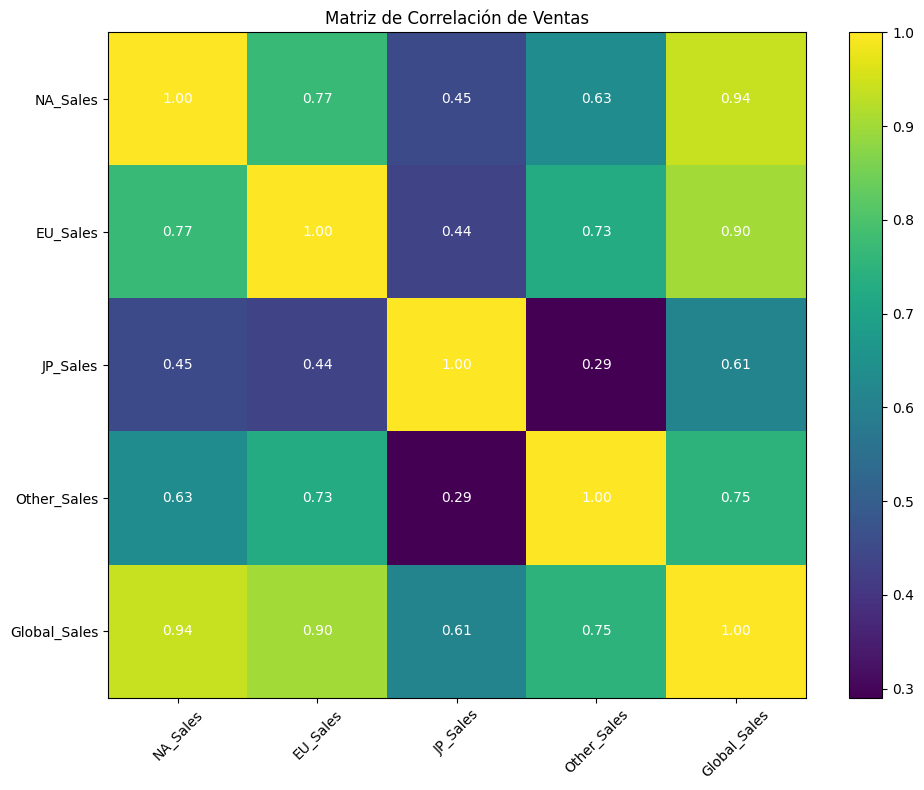

In [6]:
columnas_numericas = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

vector_assembler = VectorAssembler(
    inputCols=columnas_numericas,
    outputCol="features"
)
vector_df = vector_assembler.transform(df)

pearson_matrix = Correlation.corr(vector_df, "features").collect()[0][0]
correlation_matrix = pearson_matrix.toArray()

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='viridis', aspect='auto')

for i in range(len(columnas_numericas)):
    for j in range(len(columnas_numericas)):
        plt.text(j, i, f"{float(correlation_matrix[i][j]):.2f}", 
                ha="center", va="center", color='white')


plt.colorbar()
plt.xticks(range(len(columnas_numericas)), columnas_numericas, rotation=45)
plt.yticks(range(len(columnas_numericas)), columnas_numericas)
plt.title("Matriz de Correlación de Ventas")
plt.tight_layout()

plt.show()

Al observar el grafico de correlacion se puede notar que la correlacion principal se encuentra en la relacion con las mismas columnas, hay pocas columnas que tienen correlacion entre si, por ejemplo las ventas globalas con las ventas de norte america, euripa y otras. Esto nos puede indicar que las ventas globales y las ventas en cada region estan relacionadas ya que las ventas por region afectan directamente a las ventas globales.

Para el tratamiento de los datos se va a realizar lo siguiente:
- Al analizar las columnas y la naturaleza de lo que representa el data set, los outliers se dejaran intactos, esto debido a que se considera que pueden ser datos utiles ya que puede ser las ventas de un juego que fue un exito o las ventas fueron tan bajas que el juego fue un fracaso.
- Para tratar los valores que poseen 0 se multiplicara la columna por 1 000 000, ya que las ventas fueron en millones entonces esto nos ayudara a poder observar los valores reales de las ventas.

Dicho esto se utilizara el siguiente codigo:

In [7]:
df_transformed = df \
    .withColumn("NA_Sales", col("NA_Sales").cast("double") * 1000000) \
    .withColumn("EU_Sales", col("EU_Sales").cast("double") * 1000000) \
    .withColumn("JP_Sales", col("JP_Sales").cast("double") * 1000000) \
    .withColumn("Other_Sales", col("Other_Sales").cast("double") * 1000000) \
    .withColumn("Global_Sales", col("Global_Sales").cast("double") * 1000000)

df_transformed.show()
df_transformed.printSchema()

+----+--------------------+--------+----+------------+--------------------+---------+-----------------+---------+------------------+------------+
|Rank|                Name|Platform|Year|       Genre|           Publisher| NA_Sales|         EU_Sales| JP_Sales|       Other_Sales|Global_Sales|
+----+--------------------+--------+----+------------+--------------------+---------+-----------------+---------+------------------+------------+
|   1|          Wii Sports|     Wii|2006|      Sports|            Nintendo|  4.149E7|          2.902E7|3770000.0|         8460000.0|     8.274E7|
|   2|   Super Mario Bros.|     NES|1985|    Platform|            Nintendo|  2.908E7|        3580000.0|6810000.0|          770000.0|     4.024E7|
|   3|      Mario Kart Wii|     Wii|2008|      Racing|            Nintendo|  1.585E7|          1.288E7|3790000.0|         3310000.0|     3.582E7|
|   4|   Wii Sports Resort|     Wii|2009|      Sports|            Nintendo|  1.575E7|          1.101E7|3280000.0|         29

Ahora para el tratamiento de los valores nulos que se encuentran en el año se decidio que se le asiganara un año aleatorio dentro de los años que se encuentran en el dataset.

In [8]:
year_stats = df_transformed.select(
    min(col("Year")).alias("min_year"),
    max(col("Year")).alias("max_year")
).collect()[0]

min_year = year_stats["min_year"]
max_year = year_stats["max_year"]

df_filled = df_transformed.withColumn("Year", 
    when(col("Year").isNull(), 
        (rand() * (max_year - min_year) + min_year).cast("integer")
    ).otherwise(col("Year"))
)

print("Verificación de valores nulos en Year después de colocarles un año aleatorio:")
null_count = df_filled.filter(col("Year").isNull()).count()
print(f"Valores nulos restantes: {null_count}")

print("\nEjemplos de registros actualizados:")
df_filled.filter(df.Year.isNull()).select("Name", "Year").show(5)

df_filled.show()
df_filled.printSchema()

Verificación de valores nulos en Year después de colocarles un año aleatorio:
Valores nulos restantes: 0

Ejemplos de registros actualizados:
+--------------------+----+
|                Name|Year|
+--------------------+----+
|     Madden NFL 2004|1996|
|    FIFA Soccer 2004|2009|
|LEGO Batman: The ...|2003|
|wwe Smackdown vs....|2016|
|      Space Invaders|1982|
+--------------------+----+
only showing top 5 rows

+----+--------------------+--------+----+------------+--------------------+---------+-----------------+---------+------------------+------------+
|Rank|                Name|Platform|Year|       Genre|           Publisher| NA_Sales|         EU_Sales| JP_Sales|       Other_Sales|Global_Sales|
+----+--------------------+--------+----+------------+--------------------+---------+-----------------+---------+------------------+------------+
|   1|          Wii Sports|     Wii|2006|      Sports|            Nintendo|  4.149E7|          2.902E7|3770000.0|         8460000.0|     8.274E

Una vez que se ha realizado todo el tratamiento de los datos se va a proceder a insertarlos en la base de datos. Para insertar en la base de datos no es necesario que este creada la base de datos, con el comando wirte y las credenciales correctas este podra crear la tabla y almacenar la informacion.

In [9]:
df_final = df_filled.select(
    col("Rank").alias("rank"),
    col("Name").alias("name"),
    col("Platform").alias("platform"),
    col("Year").alias("year"),
    col("Genre").alias("genre"),
    col("Publisher").alias("publisher"),
    col("NA_Sales").alias("na_sales"),
    col("EU_Sales").alias("eu_sales"),
    col("JP_Sales").alias("jp_sales"),
    col("Other_Sales").alias("other_sales"),
    col("Global_Sales").alias("global_sales")
)

df_final.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("dbtable", "tarea3") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .mode("overwrite") \
    .save()

Con el codigo anterior se podra guardar los datos limpios en la base datos, con el codigo siguiente verificaremos si los datos fueron almacenados de forma que se puedan extrar los datos de manera exitosa en para poder continuar con la creacion y evaluacion del modelo.

In [10]:
df_prediction = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("dbtable", "tarea3") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .load()

print(f"Total de registros: {df_prediction.count()}")
print("\nMuestra de los primeros 5 registros:")
df_prediction.show(5)

Total de registros: 16598

Muestra de los primeros 5 registros:
+----+--------------------+--------+----+------------+---------+--------+---------+---------+-----------+------------+
|rank|                name|platform|year|       genre|publisher|na_sales| eu_sales| jp_sales|other_sales|global_sales|
+----+--------------------+--------+----+------------+---------+--------+---------+---------+-----------+------------+
|   1|          Wii Sports|     Wii|2006|      Sports| Nintendo| 4.149E7|  2.902E7|3770000.0|  8460000.0|     8.274E7|
|   2|   Super Mario Bros.|     NES|1985|    Platform| Nintendo| 2.908E7|3580000.0|6810000.0|   770000.0|     4.024E7|
|   3|      Mario Kart Wii|     Wii|2008|      Racing| Nintendo| 1.585E7|  1.288E7|3790000.0|  3310000.0|     3.582E7|
|   4|   Wii Sports Resort|     Wii|2009|      Sports| Nintendo| 1.575E7|  1.101E7|3280000.0|  2960000.0|       3.3E7|
|   5|Pokemon Red/Pokem...|      GB|1996|Role-Playing| Nintendo| 1.127E7|8890000.0|  1.022E7|  1000000.

Una vez que se realizo la confirmacion que los datos fueron insertados de manera exitosa se va a proceder a realizar la prediccion que se menciono al inicio del notebook, que es ver si cada video juego le genero perdidas o ganancias a su respectiva compañia.

In [15]:
features = ["na_sales", "eu_sales", "jp_sales", "other_sales", "global_sales"]

assembler = VectorAssembler(inputCols=features, outputCol="features")

percentil_75 = df_prediction.approxQuantile("global_sales", [0.75], 0.01)[0]
data = df_prediction.withColumn(
    "label",
    when(col("global_sales") >= percentil_75, 1.0).otherwise(0.0)
)

data_vectorized = assembler.transform(data)
train_data, test_data = data_vectorized.randomSplit([0.7, 0.3], seed=42)

dt = DecisionTreeClassifier(
    featuresCol="features",
    labelCol="label",
    seed=42
)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)

paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.minInstancesPerNode, [1, 2, 4]) \
    .build()

crossval = CrossValidator(
    estimator=dt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,
    seed=42
)

cv_model = crossval.fit(train_data)

best_model = cv_model.bestModel
print("\nMejores parámetros:")
print(f"MaxDepth: {best_model.getMaxDepth()}")
print(f"MinInstancesPerNode: {best_model.getMinInstancesPerNode()}")

predictions = cv_model.transform(test_data)
accuracy_decision = evaluator.evaluate(predictions)
print(f"\nAccuracy del modelo: {accuracy_decision:.4f}")
precision_decision = evaluator_precision.evaluate(predictions)
print(f"Precisión del modelo: {precision_decision:.4f}")

predictions_labeled = predictions.withColumn(
    "resultado",
    when(col("prediction") == 1.0, "Ganancia")
    .otherwise("Pérdida")
)

predictions_detailed = predictions_labeled.select(
    "name",
    "platform",
    "year",
    "genre",
    "publisher",
    "global_sales",
    "na_sales",
    "eu_sales", 
    "jp_sales",
    "other_sales",
    "prediction",
    "resultado"
).dropDuplicates(["name", "platform", "year", "publisher"])

predictions_detailed.show()


Mejores parámetros:
MaxDepth: 10
MinInstancesPerNode: 4

Accuracy del modelo: 0.9916
Precisión del modelo: 0.9916
+--------------------+--------+----+------------+--------------------+------------+---------+--------+--------+-----------+----------+---------+
|                name|platform|year|       genre|           publisher|global_sales| na_sales|eu_sales|jp_sales|other_sales|prediction|resultado|
+--------------------+--------+----+------------+--------------------+------------+---------+--------+--------+-----------+----------+---------+
|.hack//G.U. Vol.2...|     PS2|2006|Role-Playing|  Namco Bandai Games|    230000.0| 110000.0| 90000.0|     0.0|    30000.0|       0.0|  Pérdida|
|.hack//Infection ...|     PS2|2002|Role-Playing|               Atari|   1270000.0| 490000.0|380000.0|260000.0|   130000.0|       1.0| Ganancia|
|         .hack//Link|     PSP|2010|Role-Playing|  Namco Bandai Games|    140000.0|      0.0|     0.0|140000.0|        0.0|       0.0|  Pérdida|
|.hack//Mutatio

In [16]:
predictions_detailed.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("dbtable", "modelo1") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .mode("overwrite") \
    .save()

Para el modelo 1 de predicciones se utilizo un Decision Tree el cual se establecio que los juegos que estuvieran por encima del 3 cuartil que seria el 75% de las ventas globales serian ganancias y se identificaria con un 1, de lo contrario se identificara con un 0 como una perdida. Para esto se dividio el conjunto de datos en train con un 70% de los datos y en test con un 30% de los datos para entrenar y probar el modelo. Al utilizar un Decision Tree se utilizaron los hiperparametros de que se probara con una profundidad de 5, 10 y 15 el cual es la profundidad del arbol y que contara con 1, 2 y 4 nodos que son los ejemplos minimos para poder tomar una decision.

Al utilizar este modelo de clasificacion se obtiene que los mejores hiperparametros son que los bosques deben de tener una profundidad de 10 con 4 nodos cada uno, obteniendo un accuracy de un 0.9916 y una precision de 0.9916 el cual es casi el 100%.

Tambien se obtuvo que al utilizar la funcion de randomSplit algunos registros fueron duplicados por lo que para solucionar este problema se lo utilizo la funcion "dropDuplicates" para eliminar estos registros duplicados y que no se vea afectada la integridad de los datos.

In [17]:
data_vectorized_random = assembler.transform(data)
train_data_random, test_data_random = data_vectorized_random.randomSplit([0.7, 0.3], seed=42)

rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    seed=42
)

evaluator_random = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

evaluator_precision_random = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)

paramGrid_random = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.minInstancesPerNode, [1, 2]) \
    .build()

crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid_random,
    evaluator=evaluator,
    numFolds=5,
    seed=42
)

cv_model = crossval.fit(train_data_random)

best_model = cv_model.bestModel
print("\nMejores parámetros:")
print(f"Número de árboles: {best_model.getNumTrees}")
print(f"Profundidad máxima: {best_model.getMaxDepth()}")
print(f"Instancias mínimas por nodo: {best_model.getMinInstancesPerNode()}")

predictions_random = cv_model.transform(test_data_random)
accuracy_random = evaluator_random.evaluate(predictions_random)
print(f"\nAcuracy del modelo: {accuracy_random:.4f}")
precision_random = evaluator_precision_random.evaluate(predictions_random)
print(f"Precisión del modelo: {precision_random:.4f}")

predictions_clean_random = predictions_random.select(
    "name",
    "platform",
    "year",
    "genre",
    "publisher",
    "global_sales",
    "na_sales",
    "eu_sales", 
    "jp_sales",
    "other_sales",
    "prediction"
).dropDuplicates(["name", "platform", "year", "publisher"])

predictions_labeled_random = predictions_clean_random.withColumn(
    "resultado",
    when(col("prediction") == 1.0, "Ganancia")
    .otherwise("Pérdida")
)

predictions_labeled_random.show()


Mejores parámetros:
Número de árboles: 30
Profundidad máxima: 5
Instancias mínimas por nodo: 1

Acuracy del modelo: 0.9897
Precisión del modelo: 0.9899
+--------------------+--------+----+------------+--------------------+------------+---------+--------+--------+-----------+----------+---------+
|                name|platform|year|       genre|           publisher|global_sales| na_sales|eu_sales|jp_sales|other_sales|prediction|resultado|
+--------------------+--------+----+------------+--------------------+------------+---------+--------+--------+-----------+----------+---------+
|.hack//G.U. Vol.2...|     PS2|2006|Role-Playing|  Namco Bandai Games|    230000.0| 110000.0| 90000.0|     0.0|    30000.0|       0.0|  Pérdida|
|.hack//Infection ...|     PS2|2002|Role-Playing|               Atari|   1270000.0| 490000.0|380000.0|260000.0|   130000.0|       1.0| Ganancia|
|         .hack//Link|     PSP|2010|Role-Playing|  Namco Bandai Games|    140000.0|      0.0|     0.0|140000.0|        0.0

In [18]:
predictions_labeled_random.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("dbtable", "modelo2") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .mode("overwrite") \
    .save()

Para el modelo 2 se utilizo Random Forest el cual de manera similar al Desicion Tree se utilizaron hiperparametros para que se probaran bosques con 10, 20 o 30 abroles y que se probara si la profundidad de cada arbol fuera de 5 o 10, y que las instancias por nodo fueran 1 o 2, teniendo asi que los mejores parametros son:
- Número de árboles: 30
- Profundidad máxima: 5
- Instancias mínimas por nodo: 1

Se obtuvieron resultados muy similares al Decision Tree, solo que el Decision Tree tiene un rendimiento un poco mejor , por un 0.0071 lo cual es una diferencia muy poca. Para ambos modelos se puede concluir que son muy buenos para realizar la prediccion del conjunto de datos, pero si se recomienda uno se recomendaria el Decision Tree por que es un poco superior de acuerdo a las metricas que se utilizaron para evaluar el modelo.

In [19]:
print(f"\nAccuracy del modelo decision tree: {accuracy_decision:.4f}")
print(f"Precisión del modelo decision tree: {precision_decision:.4f}")

print(f"\nAcuracy del modelo random forest: {accuracy_random:.4f}")
print(f"Precisión del modelo random forest: {precision_random:.4f}")


Accuracy del modelo decision tree: 0.9916
Precisión del modelo decision tree: 0.9916

Acuracy del modelo random forest: 0.9897
Precisión del modelo random forest: 0.9899
